In [66]:
from dataclasses import dataclass

@dataclass
class SimulationParameters:
    service_lambda: float
    on_off_lambda: float
    capacity: int
    loss_probability: float
    message_lambda: float
    message_lifetime: int
    
    def __hash__(self) -> int:
        return int(7 * self.service_lambda + 10 * self.on_off_lambda + 2 * self.capacity + 3 * self.loss_probability + 4 * self.message_lambda + self.message_lifetime)
    
@dataclass
class SimulationResults:
    n_messages_generated: int
    n_messages_lost: int
    n_messages_expired: int
    n_messages_completed: int
    averate_response_time: float

In [67]:
from main import MessageGenerator, OnOffServer, Sink, MessageState, Simulation, Message
from typing import Dict, List

arrival_rate_simulation_parameters_list: List[SimulationParameters] = []

for message_lambda in range(0, 10):
    arrival_rate_simulation_parameters_list.append(
        SimulationParameters(1, 1, 1, 1, message_lambda * 0.5, 100000)
    )


arrival_rate_simulation_results: Dict[SimulationParameters, SimulationResults] = dict()

for simulation_parameters in arrival_rate_simulation_parameters_list:
    message_generator = MessageGenerator(l=simulation_parameters.message_lambda, lifetime=simulation_parameters.message_lifetime)
    server = OnOffServer(
        service_lambda=simulation_parameters.service_lambda, state_flop_lambda=simulation_parameters.on_off_lambda, capacity=simulation_parameters.capacity, loss_probability=simulation_parameters.loss_probability
    )
    sink = Sink("Completed Messages", MessageState.COMPLETED)
    lostSink = Sink("Lost / Expired Messages")

    message_generator.register_output_listener(server)
    server.register_output_listener(sink)
    server.register_loss_output_listener(lostSink)

    simulation = Simulation()
    simulation.register_component(message_generator)
    simulation.register_component(server)
    simulation.register_component(sink)
    simulation.register_component(lostSink)

    # Simulate for 10000ms -> 10s
    simulation.simulate(0, 10000)
    
    if simulation_parameters in arrival_rate_simulation_results.keys():
        raise ValueError("Hashing Function failed to create unique hash")
    
    arrival_rate_simulation_results[simulation_parameters] = SimulationResults(
        n_messages_generated=message_generator.n_messages_generated,
        n_messages_lost=len([message for message in lostSink.messages if message.state is MessageState.LOST]),
        n_messages_expired=len([message for message in lostSink.messages if message.state is MessageState.EXPIRED]),
        n_messages_completed=len([message for message in sink.messages if message.state is MessageState.COMPLETED]),
        averate_response_time=((sum([message.response_time() for message in sink.messages]) / message_generator.n_messages_generated) if message_generator.n_messages_generated > 0 else 0)
    )

0.0 0
0.5 826.25
1.0 401.09090909090907
1.5 301.05
2.0 140.78571428571428
2.5 215.0
3.0 257.0810810810811
3.5 204.575
4.0 166.62962962962962
4.5 47.30434782608695


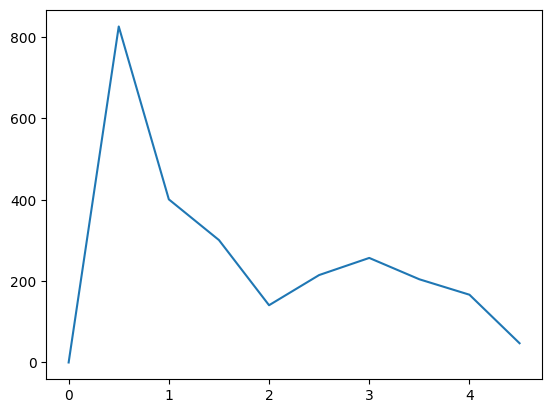

In [68]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()

arrival_rate_message_lambdas: List[float] = []
arrival_rate_response_times: List[float] = []

for (parameters, results) in arrival_rate_simulation_results.items():
    arrival_rate_message_lambdas.append(parameters.message_lambda)
    arrival_rate_response_times.append(results.averate_response_time)
    print(parameters.message_lambda, results.averate_response_time)

ax.plot(arrival_rate_message_lambdas, arrival_rate_response_times)



